In [1]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
%matplotlib inline
# %env CUDA_VISIBLE_DEVICES= 0,1

In [25]:
# load data
train_X = np.load("all_img.npy")
train_attr = pd.read_csv("./hw4_data/train.csv")
test_attr = pd.read_csv("./hw4_data/test.csv")

# smiling_attr = np.hstack((np.repeat(np.array(train_attr["Smiling"]),2) 
#                           ,np.repeat(np.array(test_attr["Smiling"]),2)
#                          ))
smiling_attr = np.hstack((np.array(train_attr["Smiling"])
                          ,np.array(test_attr["Smiling"]))
                         )

In [26]:
# type transform
img_X = torch.from_numpy(train_X).type(torch.FloatTensor)
class_X = torch.from_numpy(smiling_attr).type(torch.FloatTensor).view(-1,1,1,1)

In [28]:
random.seed(38)
torch.manual_seed(38)
# use for random generation
up = np.ones(10)
down = np.zeros(10)
fixed_class = np.hstack((up,down))
fixed_class = torch.from_numpy(fixed_class).view(20,1,1,1).type(torch.FloatTensor)
fixed_noise = torch.randn(10, 100, 1, 1)
fixed_noise = torch.cat((fixed_noise,fixed_noise))
fixed_input = Variable(torch.cat((fixed_noise, fixed_class),1)).cuda()

In [30]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 101, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
            
    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output
    
class Discriminator(nn.Module):
    def __init__(self, figsize=64):
        super(Discriminator, self).__init__()
        self.decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(figsize * 8, figsize * 1, 4, 1, 0),
        )
        self.fc_dis = nn.Linear(figsize * 1, 1)
        # aux-classifier fc
        self.fc_aux = nn.Linear(figsize * 1, 1) # one class
        
        # softmax and sigmoid
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        decode_output = self.decoder(X)
        flat = decode_output.view(-1,64)
        fc_dis = self.fc_dis(flat)
        fc_aux = self.fc_aux(flat)
        
        realfake = self.sigmoid(fc_dis)
        classes = self.sigmoid(fc_aux)
        
        return realfake, classes

In [36]:
# loss functions
dis_criterion = nn.BCELoss()
aux_criterion = nn.BCELoss()

# training
latent_size = 100
BATCH_SIZE = 64
G = nn.DataParallel(Generator(), device_ids=[0, 1])
D = nn.DataParallel(Discriminator(), device_ids=[0, 1])
G.cuda()
D.cuda()

# setup optimizer
beta_1 = 0.5
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(beta_1,0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1,0.999))


D_loss_list = []
G_loss_list = []
D_fake_acc_list = []
D_real_acc_list = []

D_fake_class_list = []
D_real_class_list = []

for epoch in range(100):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    D_fake_class = 0.0
    D_real_class = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = img_X[perm_index]
    train_class_sfl = class_X[perm_index]
    
#     # learning rate decay
#     if (epoch+1) == 5:
#         optimizerG.param_groups[0]['lr'] /= 2
#         optimizerD.param_groups[0]['lr'] /= 2
#         print("learning rate change!")

    if (epoch+1) == 15:
        optimizerG.param_groups[0]['lr'] /= 2
        optimizerD.param_groups[0]['lr'] /= 2
        print("learning rate change!")
    
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
        for _ in range(1):    
            # zero the parameter gradients
            D.zero_grad()
            input_X = train_X_sfl[index:index+BATCH_SIZE]
            intput_class = train_class_sfl[index:index+BATCH_SIZE]

            #### train with real image -> ground truth = real label
            real_image = Variable(input_X.cuda()) # use GPU 
            real_class = Variable(intput_class.cuda())
            real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
            dis_ouput, aux_output = D(real_image)
            D_real_dis_loss = dis_criterion(dis_ouput, real_label.view(BATCH_SIZE,1))
            D_real_aux_loss = aux_criterion(aux_output, real_class.view(BATCH_SIZE,1))
            D_real_acc += np.mean(((dis_ouput > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
            D_real_loss = (D_real_dis_loss + D_real_aux_loss)/2
            D_real_class += D_real_aux_loss.data[0]

            #### train with fake image -> ground truth = fake label
            noise = torch.randn(BATCH_SIZE, 100, 1, 1)
            fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)
            intput_vector =Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()

            fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
            fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()

            fake_image = G(intput_vector)
            dis_output, aux_output = D(fake_image.detach())
            D_fake_dis_loss = dis_criterion(dis_output, fake_label.view(BATCH_SIZE,1))
            D_fake_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
            D_fake_loss = (D_fake_dis_loss + D_fake_aux_loss)/2
            D_fake_acc += np.mean(((dis_output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
            D_fake_class += D_fake_aux_loss.data[0]
            # update D
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            epoch_D_loss+=(D_train_loss.data[0])

            optimizerD.step()
        
        #### train Generator
        for _ in range(2):
            G.zero_grad()
            # generate fake image
            noise = torch.randn(BATCH_SIZE, 100, 1, 1)
            fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)

            intput_vector = Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()

            fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()
            fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()

            fake_image = G(intput_vector)
            dis_output, aux_output = D(fake_image)
            G_dis_loss = dis_criterion(dis_output, fake_label_for_G.view(BATCH_SIZE,1))
            G_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
            G_train_loss = G_dis_loss + G_aux_loss
            G_train_loss.backward()
            optimizerG.step()
        epoch_G_loss += (G_train_loss.data[0])
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    
    print("D_real_dis_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_dis_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    print("D_real_aux_loss:", D_real_class/(total_length/BATCH_SIZE))
    print("D_fake_aux_loss:", D_fake_class/(total_length/BATCH_SIZE))
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))    
    D_real_class_list.append(D_real_class/(total_length/BATCH_SIZE))
    D_fake_class_list.append(D_fake_class/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_input)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './ACGAN_output/fig3_3_'+str(epoch+1)+'.jpg',nrow=10)
    
torch.save(G.state_dict(), "./models/ACG_model.pkt")

Epoch: 1
training D Loss: 0.014243232927268461
training G Loss: 0.017179995643066354
D_real_dis_acc: 0.49651580206940243
D_fake_dis_acc: 0.5114614861218648
D_real_aux_loss: 0.3443722772798529
D_fake_aux_loss: 0.06644114201098694
Epoch: 2
training D Loss: 0.013014385969629148
training G Loss: 0.012703320007344804
D_real_dis_acc: 0.5022641420895803
D_fake_dis_acc: 0.5360268412285024
D_real_aux_loss: 0.2642640833343279
D_fake_aux_loss: 0.01592255188834172
Epoch: 3
training D Loss: 0.012715084587559091
training G Loss: 0.012666291880760319
D_real_dis_acc: 0.5273691372797448
D_fake_dis_acc: 0.5502921095234743
D_real_aux_loss: 0.2380789716912609
D_fake_aux_loss: 0.015256144297105895
Epoch: 4
training D Loss: 0.0125929661841057
training G Loss: 0.012235404821600253
D_real_dis_acc: 0.5306773656178879
D_fake_dis_acc: 0.542479059618498
D_real_aux_loss: 0.22077755310358607
D_fake_aux_loss: 0.016400355523077764
Epoch: 5
training D Loss: 0.012495891473274342
training G Loss: 0.012142834642190146
D_

training D Loss: 0.003393217457311056
training G Loss: 0.06498996588600976
D_real_dis_acc: 0.9230426315665986
D_fake_dis_acc: 0.9205555946599094
D_real_aux_loss: 0.018906495851535345
D_fake_aux_loss: 0.022801735901362294
Epoch: 38
training D Loss: 0.0033600612565309017
training G Loss: 0.06568245260146191
D_real_dis_acc: 0.9223622158091082
D_fake_dis_acc: 0.920884071232491
D_real_aux_loss: 0.020239655604349007
D_fake_aux_loss: 0.02544784552630811
Epoch: 39
training D Loss: 0.003288436461951443
training G Loss: 0.06672172753389828
D_real_dis_acc: 0.9247788648788156
D_fake_dis_acc: 0.9220337392365265
D_real_aux_loss: 0.01793845599395602
D_fake_aux_loss: 0.021223661809168202
Epoch: 40
training D Loss: 0.003434492625394534
training G Loss: 0.06806906150812467
D_real_dis_acc: 0.9236057342624527
D_fake_dis_acc: 0.9221979775228174
D_real_aux_loss: 0.020080906240549805
D_fake_aux_loss: 0.0231031935334082
Epoch: 41
training D Loss: 0.003203462627259562
training G Loss: 0.06780043269114985
D_rea

training D Loss: 0.0022285116036628804
training G Loss: 0.08781066731222271
D_real_dis_acc: 0.9529574622838507
D_fake_dis_acc: 0.9500011731306164
D_real_aux_loss: 0.013428776818095655
D_fake_aux_loss: 0.018750323503807783
Epoch: 74
training D Loss: 0.002472727734513639
training G Loss: 0.08572553155154877
D_real_dis_acc: 0.9490626686375261
D_fake_dis_acc: 0.9484526407170174
D_real_aux_loss: 0.01421428973027879
D_fake_aux_loss: 0.021535863340182
Epoch: 75
training D Loss: 0.002261307428800223
training G Loss: 0.086545359414001
D_real_dis_acc: 0.9524178222003238
D_fake_dis_acc: 0.9504704253771615
D_real_aux_loss: 0.013940910084307206
D_fake_aux_loss: 0.01778966104366802
Epoch: 76
training D Loss: 0.002397426722366245
training G Loss: 0.08838409583591955
D_real_dis_acc: 0.9504469627648342
D_fake_dis_acc: 0.9464348560568734
D_real_aux_loss: 0.013205826707420832
D_fake_aux_loss: 0.018126866804637515
Epoch: 77
training D Loss: 0.0022661358270841263
training G Loss: 0.08759305731511983
D_real

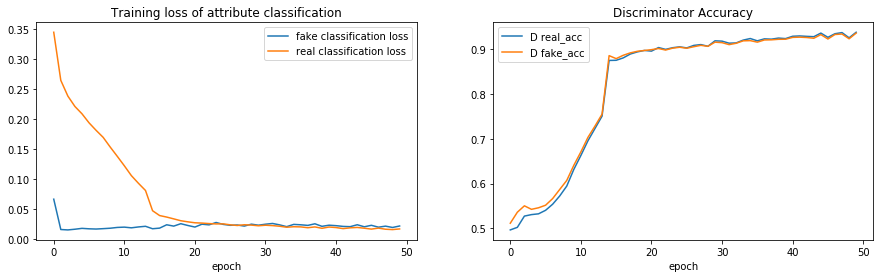

In [37]:
# plot loss
top_epochs = 50
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(D_fake_class_list[:top_epochs], label="fake classification loss")
plt.plot(D_real_class_list[:top_epochs], label="real classification loss")
plt.title("Training loss of attribute classification")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(D_real_acc_list[:top_epochs], label="D real_acc")
plt.plot(D_fake_acc_list[:top_epochs], label="D fake_acc")
plt.title("Discriminator Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.savefig("./ACGAN_output/fig3_2.jpg")
plt.show()